# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [61]:
pip install scikit-learn --upgrade

  Using cached scikit_learn-1.1.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'COPYING'
Consider using the `--user` option or check the permissions.

Note: you may need to restart the kernel to use updated packages.


In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import math


import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [63]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [64]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [65]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
1970,0,20.0,40400.0,2,0
555,0,20.0,40300.0,1,0
3565,1,28.0,30100.0,1,0
4915,0,19.0,37700.0,1,0
1438,0,43.0,45600.0,1,1
1721,1,29.0,27300.0,1,0
4916,1,24.0,46400.0,1,0
2221,0,32.0,10000.0,1,0
1528,1,27.0,36800.0,1,0
1744,1,40.0,41900.0,2,0


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [67]:
to_int = ['age', 'family_members', 'insurance_benefits']
df[to_int] = df[to_int].astype('int')

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [69]:
df.duplicated().value_counts()

False    4847
True      153
dtype: int64

In [70]:
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              4847 non-null   int64  
 1   age                 4847 non-null   int64  
 2   income              4847 non-null   float64
 3   family_members      4847 non-null   int64  
 4   insurance_benefits  4847 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 189.5 KB


In [72]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000
mean,0.498453,31.023932,39895.811842,1.203425,0.152259
std,0.500049,8.487995,9972.953985,1.098664,0.468934
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33200.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


### Conclusion

The dataset given has a 5 columns and 5000 rows. Upon checkin I changed the name of colums(made them in low register for convenience), converted columns age, family memebers and insurance benefits to int type, also droped duplicates from the dataset. Dataset hasn't missing values as well as abnormal values, which we can see from the info and describe methods. Data set is ready for further work.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

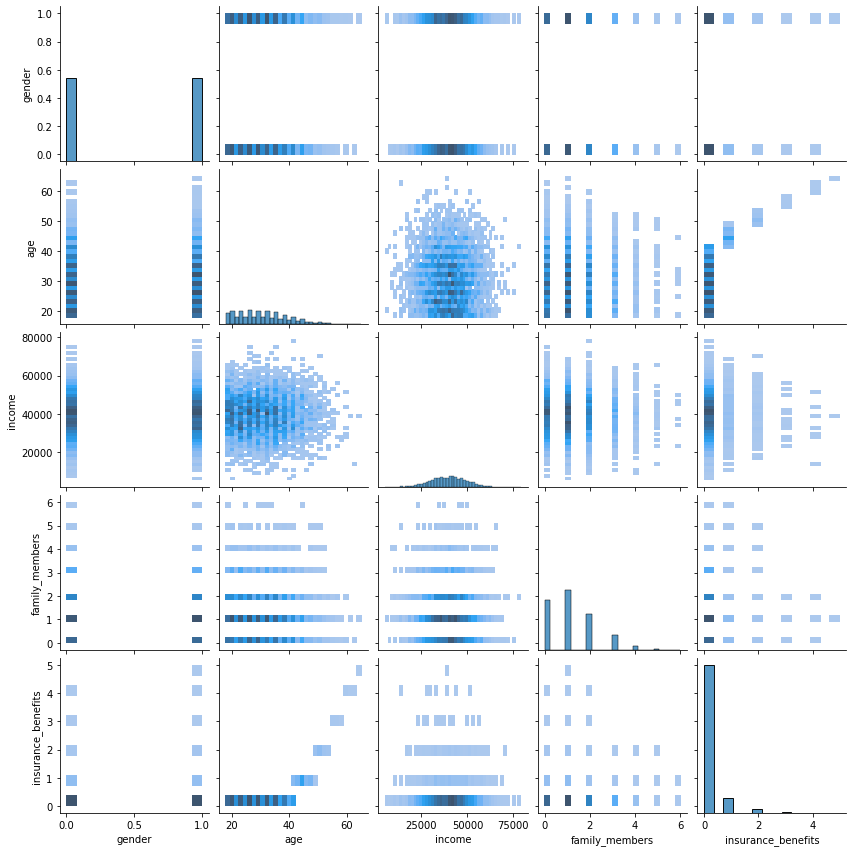

In [73]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [74]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [75]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(df[feature_names]) 
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [76]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [77]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
1553,0.0,0.569231,0.288608,0.000000,0
2760,0.0,0.369231,0.572152,0.000000,0
3020,1.0,0.400000,0.531646,0.000000,0
672,1.0,0.600000,0.449367,0.333333,0
2200,0.0,0.461538,0.550633,0.333333,0


Now, let's get similar records for a given one for every combination

**1. Not scaled manhatten distance**

In [78]:
get_knn(df, 0, 10, 'cityblock')

,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.0
1992,1,41,49600.0,0,0,1.0
1214,0,42,49600.0,0,1,3.0
3916,1,44,49600.0,2,1,4.0
3334,0,38,49600.0,0,0,5.0
810,1,37,49600.0,2,0,5.0
4520,0,45,49600.0,0,1,6.0
2094,0,37,49600.0,2,0,6.0
2311,1,46,49600.0,2,1,6.0
3790,1,36,49600.0,0,0,6.0


**2. Not scaled euclidean distance**

In [79]:
get_knn(df, 0, 10, 'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.000000
1992,1,41,49600.0,0,0,1.000000
1214,0,42,49600.0,0,1,1.732051
3916,1,44,49600.0,2,1,3.162278
3334,0,38,49600.0,0,0,3.316625
810,1,37,49600.0,2,0,4.123106
4520,0,45,49600.0,0,1,4.242641
2094,0,37,49600.0,2,0,4.242641
3790,1,36,49600.0,0,0,5.099020
2311,1,46,49600.0,2,1,5.099020


**3. Scaled manhatten distance**

In [80]:
get_knn(df_scaled, 0, 10, 'cityblock')

,gender,age,income,family_members,insurance_benefits,distance
0,1.0,0.630769,0.627848,0.166667,0,0.000000
2632,1.0,0.630769,0.634177,0.166667,0,0.006329
133,1.0,0.615385,0.636709,0.166667,0,0.024245
4720,1.0,0.646154,0.637975,0.166667,1,0.025511
2072,1.0,0.630769,0.596203,0.166667,0,0.031646
124,1.0,0.661538,0.635443,0.166667,1,0.038364
4173,1.0,0.630769,0.588608,0.166667,0,0.039241
3192,1.0,0.646154,0.651899,0.166667,1,0.039435
1550,1.0,0.615385,0.602532,0.166667,0,0.040701
3541,1.0,0.615385,0.600000,0.166667,0,0.043233


**4. Scaled euclidean distance**

In [81]:
get_knn(df_scaled, 0, 10, 'euclidean')

,gender,age,income,family_members,insurance_benefits,distance
0,1.0,0.630769,0.627848,0.166667,0,0.000000
2632,1.0,0.630769,0.634177,0.166667,0,0.006329
133,1.0,0.615385,0.636709,0.166667,0,0.017754
4720,1.0,0.646154,0.637975,0.166667,1,0.018418
3192,1.0,0.646154,0.651899,0.166667,1,0.028550
1550,1.0,0.615385,0.602532,0.166667,0,0.029624
2072,1.0,0.630769,0.596203,0.166667,0,0.031646
124,1.0,0.661538,0.635443,0.166667,1,0.031693
3541,1.0,0.615385,0.600000,0.166667,0,0.031815
3099,1.0,0.600000,0.611392,0.166667,0,0.034893


In [82]:
print('Not scaled manhatten:',get_knn(df, 0, 10, 'cityblock').index.values)
print('Not scaled euclidean:',get_knn(df, 0, 10, 'euclidean').index.values)
print('Scaled manhatten:    ',get_knn(df_scaled, 0, 10, 'cityblock').index.values)
print('Scaled euclidean:    ',get_knn(df_scaled, 0, 10, 'euclidean').index.values)

Not scaled manhatten: [   0 1992 1214 3916 3334  810 4520 2094 2311 3790]
Not scaled euclidean: [   0 1992 1214 3916 3334  810 4520 2094 3790 2311]
Scaled manhatten:     [   0 2632  133 4720 2072  124 4173 3192 1550 3541]
Scaled euclidean:     [   0 2632  133 4720 3192 1550 2072  124 3541 3099]


We can see that scaling yes changes the group of closest points. We see that the client 1992 before scaling is really close and differs only amount of family members.

In [83]:
# comparing 0 and 2022 client before scaling
get_knn(df_scaled, 0, 150, 'cityblock').query('index == 1992 or index == 0')

,gender,age,income,family_members,insurance_benefits,distance
0,1.0,0.630769,0.627848,0.166667,0,0.000000
1992,1.0,0.630769,0.627848,0.000000,0,0.166667


In [84]:
# compare 0 and 2632 client after scaling
get_knn(df, 0, 150, 'cityblock').query('index == 2632 or index == 0')

,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.0
2632,1,41,50100.0,1,0,500.0


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Yes, it does. We can see on the example that before scaling we have one pair of closest neighbors, and difference between them only in amount of family members, but as we have up to 6 faily members in the dataset even 1 family member comparing to 0 can be very impactfull. 
After scaling we have difference only in income (500$) which IMHO not such impactfull as difference in family members. But during this step it is hard to say am I right or not, we should check both options.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

Results are close

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [85]:
# calculate the target

df['insurance_benefits_received'] = df['insurance_benefits_received'] = df['insurance_benefits'].apply(lambda x: 0 if x == 0 else 1)
df_scaled['insurance_benefits_received'] = df_scaled['insurance_benefits'].apply(lambda x: 0 if x == 0 else 1)

In [86]:
df[ df['insurance_benefits'] == 0 ].head()

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
0,1,41,49600.0,1,0,0
2,0,29,21000.0,0,0,0
3,0,21,41700.0,2,0,0
4,1,28,26100.0,0,0,0
6,1,39,39700.0,2,0,0


In [87]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts()

0    4284
1     563
Name: insurance_benefits_received, dtype: int64

We can see that target is imbalanced

In [88]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [89]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [90]:
features = df.drop(['insurance_benefits', 'insurance_benefits_received'], axis=1)
target = df['insurance_benefits_received']

features_train, features_test, target_train, target_test = train_test_split(
                            features, target, test_size=0.3, random_state=10)

# scaled
features_scaled = df_scaled.drop(['insurance_benefits', 'insurance_benefits_received'], axis=1)
target_scaled = df_scaled['insurance_benefits_received']

features_scaled_train, features_scaled_test, target_scaled_train, target_scaled_test = train_test_split(
                            features_scaled, target_scaled, test_size=0.3, random_state=10)

In [91]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df), seed=42) 
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.88384568 0.        ]
 [0.11615432 0.        ]]

The probability: 0.12
F1: 0.13
Confusion Matrix
[[0.78502166 0.09882401]
 [0.1017124  0.01444192]]

The probability: 0.50
F1: 0.19
Confusion Matrix
[[0.44873117 0.4351145 ]
 [0.05921188 0.05694244]]

The probability: 1.00
F1: 0.21
Confusion Matrix
[[0.         0.88384568]
 [0.         0.11615432]]



TN is C[0,0], FP is C[0,1]
FN is C[1,0], TP is C[1,1]

When P = 0; TN and FN > 0, TP and FP == 0, so F1 undefined (as it should be)
When P = 1; TP and FP > 0, TN and FN == 0 (as it should be)

In [92]:
f1_score_test = []
for k_neighbors in range(1,11):
    neigh = KNeighborsClassifier(n_neighbors=k_neighbors, metric='cityblock')
    neigh.fit(features_train, target_train)
    y_pred_train = neigh.predict(features_train)
    y_pred_test = neigh.predict(features_test)

    print('\nNumber of knn:', k_neighbors)
    print('Train:')
    eval_classifier(target_train, y_pred_train)
    print('\nTest:')
    eval_classifier(target_test, y_pred_test)
    f1_score_test.append(sklearn.metrics.f1_score(target_test, y_pred_test))


Number of knn: 1
Train:
F1: 1.00
Confusion Matrix
[[0.88767689 0.        ]
 [0.         0.11232311]]

Test:
F1: 0.56
Confusion Matrix
[[0.85498282 0.01993127]
 [0.06872852 0.05635739]]

Number of knn: 2
Train:
F1: 0.70
Confusion Matrix
[[0.88767689 0.        ]
 [0.05188679 0.06043632]]

Test:
F1: 0.30
Confusion Matrix
[[0.87079038 0.00412371]
 [0.1024055  0.02268041]]

Number of knn: 3
Train:
F1: 0.74
Confusion Matrix
[[0.88472877 0.00294811]
 [0.04510613 0.06721698]]

Test:
F1: 0.31
Confusion Matrix
[[0.8652921  0.00962199]
 [0.10034364 0.02474227]]

Number of knn: 4
Train:
F1: 0.47
Confusion Matrix
[[0.88620283 0.00147406]
 [0.07724057 0.03508255]]

Test:
F1: 0.14
Confusion Matrix
[[0.87285223 0.00206186]
 [0.11546392 0.00962199]]

Number of knn: 5
Train:
F1: 0.48
Confusion Matrix
[[0.8853184  0.00235849]
 [0.07635613 0.03596698]]

Test:
F1: 0.16
Confusion Matrix
[[0.87216495 0.00274914]
 [0.11408935 0.01099656]]

Number of knn: 6
Train:
F1: 0.26
Confusion Matrix
[[8.87382075e-01 2.

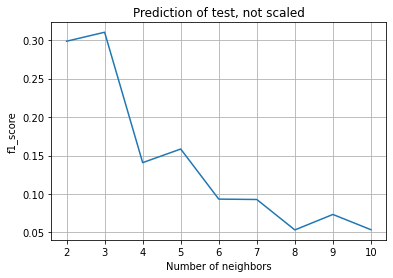

In [93]:
plt.figure
plt.plot([x + 2 for x in range(9)], f1_score_test[1:])
plt.xlabel('Number of neighbors')
plt.ylabel('f1_score')
plt.title('Prediction of test, not scaled')
plt.grid(True)

With increasing the number of neighbors the quality of prediction decreases. Optimal number of neighbors is 3 for unsxaled dataset. Let's see the results for scaled dataset.

In [94]:

f1_score_test = []
for k_neighbors in range(1,11):
    neigh_scaled = KNeighborsClassifier(n_neighbors=k_neighbors, metric='cityblock')
    neigh_scaled.fit(features_scaled_train, target_scaled_train)
    y_pred_scaled_train = neigh_scaled.predict(features_scaled_train)
    y_pred_scaled_test = neigh_scaled.predict(features_scaled_test)

    print('\nNumber of knn:', k_neighbors)
    print('Train:')
    eval_classifier(target_scaled_train, y_pred_scaled_train)
    print('\nTest:')
    eval_classifier(target_scaled_test, y_pred_scaled_test)
    f1_score_test.append(sklearn.metrics.f1_score(target_scaled_test, y_pred_scaled_test))


Number of knn: 1
Train:
F1: 1.00
Confusion Matrix
[[0.88767689 0.        ]
 [0.         0.11232311]]

Test:
F1: 0.96
Confusion Matrix
[[0.87079038 0.00412371]
 [0.00549828 0.11958763]]

Number of knn: 2
Train:
F1: 0.96
Confusion Matrix
[[0.88767689 0.        ]
 [0.00825472 0.1040684 ]]

Test:
F1: 0.92
Confusion Matrix
[[0.87353952 0.00137457]
 [0.01718213 0.10790378]]

Number of knn: 3
Train:
F1: 0.97
Confusion Matrix
[[8.86792453e-01 8.84433962e-04]
 [5.01179245e-03 1.07311321e-01]]

Test:
F1: 0.95
Confusion Matrix
[[0.87216495 0.00274914]
 [0.00962199 0.11546392]]

Number of knn: 4
Train:
F1: 0.95
Confusion Matrix
[[8.87382075e-01 2.94811321e-04]
 [1.06132075e-02 1.01709906e-01]]

Test:
F1: 0.92
Confusion Matrix
[[0.87491409 0.        ]
 [0.01924399 0.10584192]]

Number of knn: 5
Train:
F1: 0.96
Confusion Matrix
[[0.88649764 0.00117925]
 [0.00707547 0.10524764]]

Test:
F1: 0.95
Confusion Matrix
[[0.87491409 0.        ]
 [0.01099656 0.11408935]]

Number of knn: 6
Train:
F1: 0.94
Conf

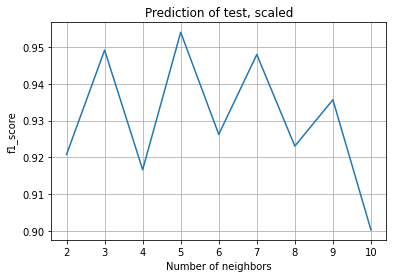

In [95]:
plt.figure
plt.plot([x + 2 for x in range(9)], f1_score_test[1:])
plt.xlabel('Number of neighbors')
plt.ylabel('f1_score')
plt.title('Prediction of test, scaled')
plt.grid(True)

For the scaled dataset results are much more better, we can see that quality of prediction doesn't depend on number of neighbors.

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [96]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(np.dot(X2.T, X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [97]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [98]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.77366729e-01  3.58042291e-02  1.95594888e-02  5.85336165e-07
 -1.21618420e-02]
RMSE: 0.36
R2: 0.66


In [99]:
X_scaled = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y_scaled = df_scaled['insurance_benefits'].to_numpy()

X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(
            X_scaled, y_scaled, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_scaled_train, y_scaled_train)
print(lr.weights)

y_scaled_test_pred = lr.predict(X_scaled_test)
eval_regressor(y_scaled_test, y_scaled_test_pred)

[-0.97736673  2.32727489  0.01955949  0.04624156 -0.07297105]
RMSE: 0.36
R2: 0.66


# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [100]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [101]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [102]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [103]:
try:
    print(np.linalg.inv(P))
except:
    print('The matrix is not invertable. Create another one.')

[[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


Can you guess the customers' ages or income after the transformation?

In [104]:
X_encrypted = X.dot(P)
X_encrypted

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [105]:
X_restored = X_encrypted.dot(np.linalg.inv(P))
print('Difference:')
X_restored - X

Difference:


array([[-4.24105195e-14, -2.13162821e-14,  0.00000000e+00,
         1.66155978e-12],
       [ 1.67952800e-12,  4.99511543e-12, -1.45519152e-11,
         1.26254562e-12],
       [-6.23021448e-13,  2.48689958e-13, -3.63797881e-12,
        -2.03032656e-13],
       ...,
       [ 1.57996161e-12,  1.63780101e-12,  0.00000000e+00,
        -2.14739337e-12],
       [-4.91384711e-13,  3.21875859e-12, -3.63797881e-12,
         7.14983628e-14],
       [ 2.44626541e-12,  2.84217094e-12, -7.27595761e-12,
         1.46838097e-12]])

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [106]:
print(X)
print(X_encrypted)
print(X_restored)

[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]
[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [ 1.67952800e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-6.23021448e-13  2.90000000e+01  2.10000000e+04 -2.03032656e-13]
 ...
 [ 1.57996161e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.27000000e+04  3.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  4

You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

On my opinion the reason hides in in float numbers. We got an error while computing.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

$w$ and $w_P$ connected by $P^{-1}$. The same as with $w$, $\hat{y}_{p}$ = $\hat{y}$. Because $\hat{y}_{p}$ = $\hat{y}$ the RMSE same the quality won't change.

**Analytical proof**

$w_P = [(XP)^TXP]^-1(XP)^T_y \Longrightarrow w_p = [P^TX^TXP]^-1P^TX^T_y \Longrightarrow 
w_p = P^-1X^-1(X^T)^-1(P^T)^-1P^TX^T_y \Longrightarrow w_p = P^-1X^-1(X^T)^-1X^T_y \Longrightarrow
w_p = P^-1(X^TX)^-1X^T_y \Longrightarrow w_p = P^-1w$
And

$w$ = $P_wp$
$\hat{y} = X_{val}w$
$\hat{y} = X_{val}Pw_p = X{val}PP^-1w = X_{val}w = \hat{y}$
So, $\hat{y}_p = \hat{y}$


## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [107]:
#random matrix P
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

In [108]:
#checking if matrix invertible:
try:
    print(np.linalg.inv(P))
except:
    print('The matrix is not invertable. Create another one.')

[[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


In [109]:
class MyLinearRegression_obfuscated:
    
    def __init__(self, obfuscation):
        
        self.weights = None
        self.obfus = obfuscation
    
    def fit(self, X, y, P):
        
        if self.obfus == True:
        # adding the unities
            X2 = np.append(np.ones([len(X.dot(P)), 1]), X.dot(P), axis=1)            
        else:
            X2 = np.append(np.ones([len(X), 1]), X, axis=1)
            
        self.weights = np.linalg.inv(np.dot(X2.T, X2)).dot(X2.T).dot(y)

    def predict(self, X, P):
        
        # adding the unities
        if self.obfus == True:
            X2 = np.append(np.ones([len(X.dot(P)), 1]), X.dot(P), axis=1)
        else:
            X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [110]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')   

In [111]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()
X_encrypted = X.dot(P)

X_train, X_test, y_train, y_test = train_test_split(X_encrypted, y, test_size=0.3, random_state=12345)

obfuscation = True
lr = MyLinearRegression_obfuscated(obfuscation)

lr.fit(X_train, y_train, P)
print(lr.weights)

y_test_pred = lr.predict(X_test, P)
eval_regressor(y_test, y_test_pred)

[-0.97736667  0.09751926  0.00462479 -0.29280775  0.21045224]
RMSE: 0.36
R2: 0.66


In [112]:
obfuscation = False
lr = MyLinearRegression_obfuscated(obfuscation)

lr.fit(X_train, y_train, P)
print(lr.weights)

y_test_pred = lr.predict(X_test, P)
eval_regressor(y_test, y_test_pred)

[-0.97736673 -0.02714044 -0.04374256  0.1010488  -0.01541924]
RMSE: 0.36
R2: 0.66


As we can see there is no difference between original and obfuscation data.

# Conclusions

We have a dataset from the insurance company. During loading and checking the data we can see that there were no missing values or abnormal values. Changes were made in the preprocessing were minimal, i just corrected titles of columns, data type and dropped duplicates. Upon EDA I couldn't see any usefull information, in this case I think need to look closely to the data, build more visualisations and make more deep analisys. The 4 tasks were solved during this project.

  **- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.**
  
  A similar client have been found with help of knn algorithm. As we were able to see scaling has much more impact on the resulats then metric (euclidean  and manhatten distance). The reason is we have a float type for income and int type for age, gender and family members columns. Float type gives us a wide range which has a big weight.
  
  **- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?** 
  
  The KNeighborsClassifier gives a good result here. Besides that interesting that scaled dataset showed independence from the amount of neighbors.
  
  **- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.**
  
  Linear models doesn't predict good here. We can try use other models to see which results we will have.
  
  **- Task 4: Protect clients' personal data without breaking the model from the previous task.**  
  
  Original and obfuscation data were running with the Linear regression model and no differences in results showed up.

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>